<a href="https://www.kaggle.com/agustinlehmann/churn-preddict?scriptVersionId=82541841" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_columns", None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = df.dropna(how="all")
df = df.drop_duplicates()

total_charges_filter = df.TotalCharges == " "
df = df[~total_charges_filter]
df.TotalCharges = pd.to_numeric(df.TotalCharges)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
categorical_features = [
 "gender","SeniorCitizen","Partner","Dependents","PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling","PaymentMethod"
]
numerical_features = ["tenure","MonthlyCharges","TotalCharges"]
target = "Churn"

In [4]:
df[numerical_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


array([<AxesSubplot:title={'center':'tenure'}>,
       <AxesSubplot:title={'center':'MonthlyCharges'}>,
       <AxesSubplot:title={'center':'TotalCharges'}>], dtype=object)

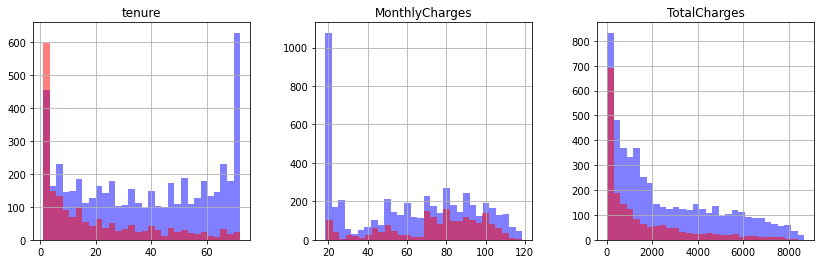

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
df[df.Churn == "No"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.Churn == "Yes"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

 According to the histograms (blue histogram represents clients that didn't churn and red the ones that did), clients tent to churn way more often on the 
 first months and ,in a lesser extent, when the monthly charges are between 60-100.


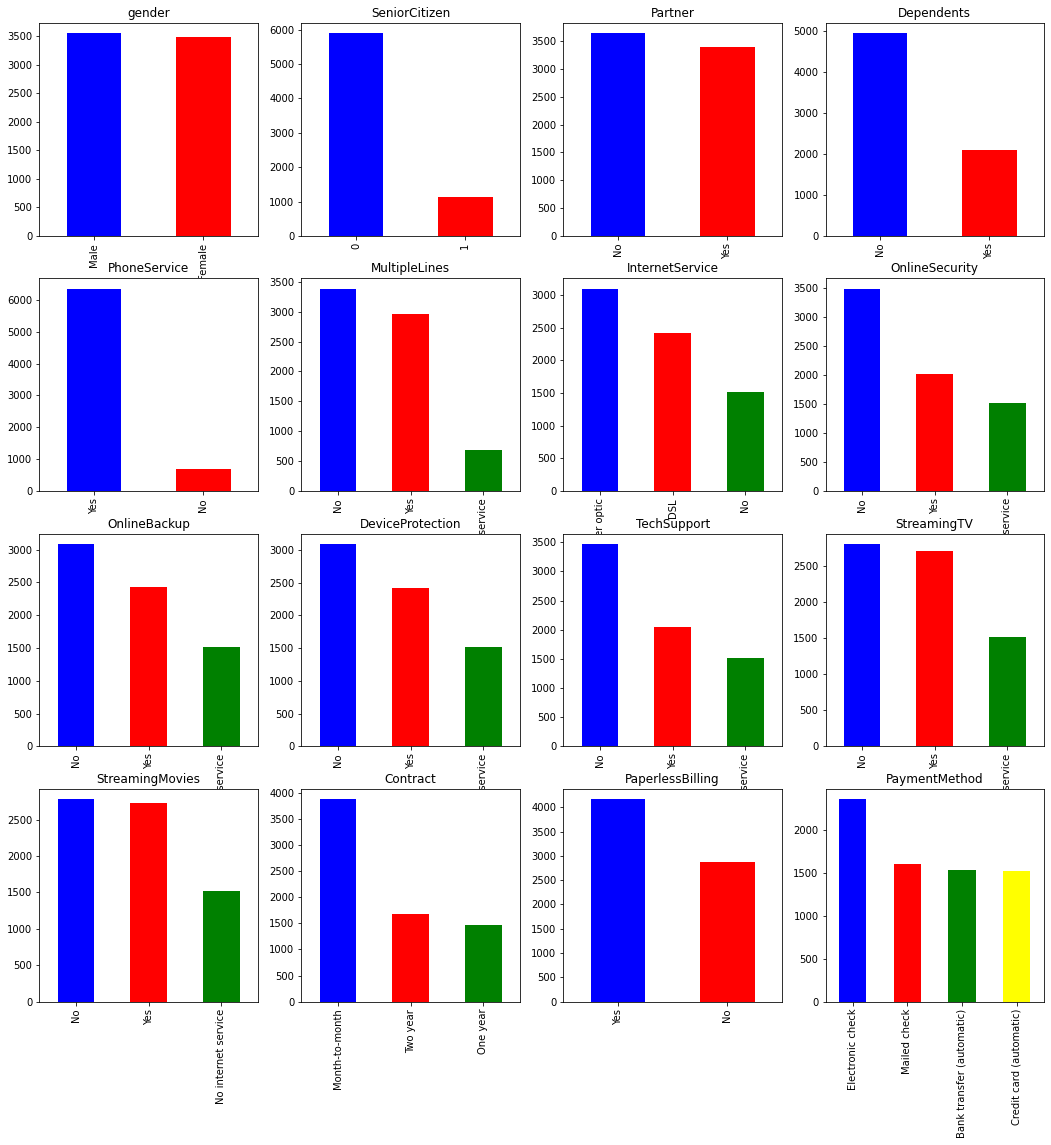

In [6]:
ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 18))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot(kind='bar', ax=ax[row, col],color=['blue', 'red', 'green', 'yellow']).set_title(categorical_feature)

Senior citizens and clients without phone service are misrepresented

Text(0.5, 1.0, 'churned')

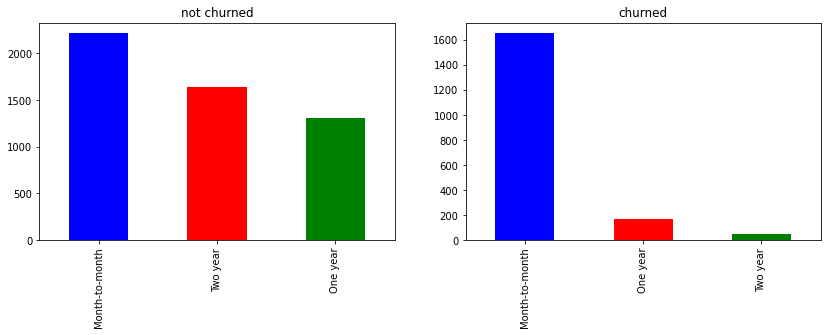

In [7]:
feature = "Contract"
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df[df.Churn == "No"][feature].value_counts().plot(kind="bar", ax=ax[0],color=['blue', 'red', 'green', 'yellow']).set_title("not churned")
df[df.Churn == "Yes"][feature].value_counts().plot(kind="bar", ax=ax[1],color=['blue', 'red', 'green', 'yellow']).set_title("churned")

Clients that have a month to month contrac tend to churn way more often

Text(0.5, 1.0, 'churned')

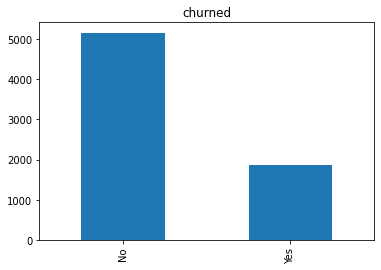

In [8]:
df[target].value_counts().plot(kind='bar').set_title('churned')

the data set is imbalanced, the amount of "no churned" is bigger than the "churned" meaning that the model will tend to have more accuracity with non churned clients.

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, df):
        return df[self.key]

In [10]:
pipeline = Pipeline(
        [
            ("union",FeatureUnion(
                transformer_list=[
                    (
                    "categorical_features",Pipeline(
                        [
                            ("selector",ItemSelector(key=categorical_features)),
                            ("onehot",OneHotEncoder()),
                        ]
                    ),
                )
            ] +[
                    (
                    "numerical_features",Pipeline(
                    [
                        ("selector",ItemSelector(key=numerical_features)),
                        ("scalar",StandardScaler()),
                    ]
                    )
                )
            ]
        )
    ),
            ("classifier", DecisionTreeClassifier(max_depth=3,random_state=42))
    ])

In [11]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
pipeline.fit(df_train, df_train[target])
pred = pipeline.predict(df_test)

In [12]:
from sklearn.metrics import classification_report
print(classification_report(df_test[target], pred))

              precision    recall  f1-score   support

          No       0.81      0.94      0.87      1300
         Yes       0.67      0.37      0.48       458

    accuracy                           0.79      1758
   macro avg       0.74      0.65      0.67      1758
weighted avg       0.77      0.79      0.77      1758



As expected, this model is more precise with customers that do not churn

Lets try to fix it with under sampling, which means to try to even the amount of churned and not churned by removeing samples from the mayority group(not churned in this case)

In [13]:
churned = df.Churn == "Yes"
churned.loc[df.Churn == "Yes"]

not_churned = df.Churn == "No"
churned.loc[df.Churn == "No"]

0       False
1       False
3       False
6       False
7       False
        ...  
7037    False
7038    False
7039    False
7040    False
7042    False
Name: Churn, Length: 5163, dtype: bool

In [14]:
remove_amount=df[not_churned].Churn.count() - df[churned].Churn.count() 
drop_indices = np.random.choice(df[not_churned].index, remove_amount, replace=False)
balanced_df =df.drop(drop_indices)

Text(0.5, 1.0, 'churned')

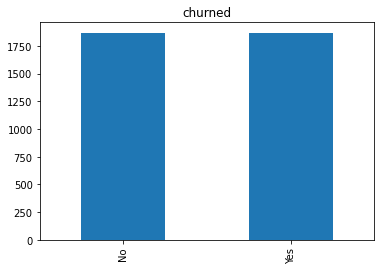

In [15]:
balanced_df[target].value_counts().plot(kind='bar').set_title('churned')

In [16]:
df_train, df_test = train_test_split(balanced_df, test_size=0.25, random_state=42)
pipeline.fit(df_train, df_train[target])
pred = pipeline.predict(df_test)

In [17]:
print(classification_report(df_test[target], pred))

              precision    recall  f1-score   support

          No       0.77      0.76      0.77       474
         Yes       0.76      0.77      0.76       461

    accuracy                           0.76       935
   macro avg       0.76      0.76      0.76       935
weighted avg       0.76      0.76      0.76       935



As we can see here the precision of predicting clients that churn and don't churn is more even now meaning that the model will be more accurate than the previus one that had an imbalanced dataset and this model can predict clients that will churn with a much higher precision than the older one, the downside of undersampling is that we loose a bit of precision on the not churned group.